In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import xgboost
import os
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [0]:
train = pd.read_csv('/content/drive/My Drive/new_model/training_large_vx_vy_vz_2.csv')#,header = None)
test = pd.read_csv('/content/drive/My Drive/new_model/validation_large_vx_vy_vz_2.csv')#,header = None)

In [12]:
train.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vx_lag_2,vy_lag_1,vy_lag_2,vz_lag_1,vz_lag_2
0,-10.861781,-2.179386,-0.006538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-0.679845,0.268508,0.006225,-10.930109,-10.954589,-2.152400,-2.117917,-0.005913,0.012756
1,-10.822652,-2.210152,-0.011221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.389326,0.306114,0.046590,-10.861781,-10.930109,-2.179386,-2.152400,-0.006538,-0.005913
2,-10.776157,-2.238142,-0.011096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.462608,0.278494,-0.001239,-10.822652,-10.861781,-2.210152,-2.179386,-0.011221,-0.006538
3,-10.738884,-2.270775,-0.017484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.370861,0.324686,0.063559,-10.776157,-10.822652,-2.238142,-2.210152,-0.011096,-0.011221
4,-10.702093,-2.299289,-0.027242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-0.366060,0.283704,0.097093,-10.738884,-10.776157,-2.270775,-2.238142,-0.017484,-0.011096


In [16]:

print(train.shape, test.shape)

(156765, 21) (29454, 22)


In [0]:
X = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                 'vx_lag_1','vy_lag_1','vz_lag_1','vx_lag_2','vy_lag_2','vz_lag_2']]
Y_ax = train.loc[:,['ax']].values.ravel() # flatten to 1d array
Y_ay = train.loc[:,['ay']].values.ravel()
Y_az = train.loc[:,['az']].values.ravel()


# y = Y_ax
X_train_ax, X_test_ax, y_train_ax, y_test_ax = train_test_split(X, Y_ax)
X_train_ay, X_test_ay, y_train_ay, y_test_ay = train_test_split(X, Y_ay)
X_train_az, X_test_az, y_train_az, y_test_az = train_test_split(X, Y_az)

In [0]:
def stacking_model(X_train,y_train):
    
    lasso = Lasso(alpha = 1e-3)
    GBC = GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3)
    LGB = LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=800)
    XGB = xgboost.XGBRegressor(gamma=0.05,learning_rate=0.05, max_depth=3, n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85)

    categorical = X_train.dtypes == object
    model_SR = make_pipeline(RobustScaler(), StackingRegressor(regressors=[LGB,lasso,XGB], meta_regressor=lasso))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_median_absolute_error',cv=5, n_jobs = -1)
    print("Stacking Regressor score: ", -scores.mean(), ' std: ', scores.std())
    
    return model_SR

In [19]:
model_SR = stacking_model(X_train_ax,y_train_ax)

Stacking Regressor score:  0.07419189599202769  std:  0.0010956232652002396


In [20]:
test.head(2)

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vx_lag_2,vy_lag_1,vy_lag_2,vz_lag_1,vz_lag_2,pred_ax
0,-1.526878,-0.108901,-0.017838,19.787335,1.781145,1.513234,0.096556,0.017846,0.131049,-0.189679,-0.136688,27.0,-0.131177,0.189820,0.136591,-1.540062,-1.602124,-0.089823,-0.096249,-0.004110,-0.00029,-0.429615
1,-1.481712,-0.096803,-0.014761,19.638062,1.751421,1.468087,0.084437,0.014786,0.449209,0.120582,0.030447,27.0,-0.449395,-0.120376,-0.030618,-1.526878,-1.540062,-0.108901,-0.089823,-0.017838,-0.00411,-0.581069


In [0]:
X_val = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels',
                    'vx_lag_1','vy_lag_1','vz_lag_1','vx_lag_2','vy_lag_2','vz_lag_2']]
y_val_ax = test.loc[:, ['ax']].values.ravel()
y_val_ay = test.loc[:, ['ay']].values.ravel()
y_val_az = test.loc[:, ['az']].values.ravel()


In [33]:
model_SR.fit(X_train_ax,y_train_ax)
yx_pred_SR = model_SR.predict(X_val)
print("MAE of SR for ax:", mean_absolute_error(y_val_ax,yx_pred_SR))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14520.321308066306, tolerance: 4.045319874222702
  positive)


[14:11:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR: 0.13564112483476265


In [32]:
model_SR.fit(X_train_ay,y_train_ay)
yy_pred_SR = model_SR.predict(X_val)
print("MAE of SR for ay:", mean_absolute_error(y_val_ay,yy_pred_SR))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14640.178301691034, tolerance: 4.094318563924868
  positive)


[14:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR: 0.09939852855697086


In [34]:
model_SR.fit(X_train_az,y_train_az)
yz_pred_SR = model_SR.predict(X_val)
print("MAE of SR for az:", mean_absolute_error(y_val_az,yz_pred_SR))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.65284141250757, tolerance: 1.0845432794016427
  positive)


[14:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of SR for az: 0.0024232427907149483


In [0]:
test['pred_ax'] = yx_pred_SR #ax prediction

test['pred_ay'] = yy_pred_SR #ay prediction

test['pred_az'] = yz_pred_SR #az prediction

In [0]:
test.to_csv(os.getcwd()+'/drive/My Drive/new_model/test_results_stacking_model.csv')

In [59]:
test.head(200)

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az,vx_lag_1,vx_lag_2,vy_lag_1,vy_lag_2,vz_lag_1,vz_lag_2,pred_ax,pred_ay,pred_az
0,-1.526878,-0.108901,-0.017838,19.787335,1.781145,1.513234,0.096556,0.017846,1.310494e-01,-1.896789e-01,-1.366879e-01,27.0,-0.131177,0.189820,0.136591,-1.540062,-1.602124,-0.089823,-0.096249,-0.004110,-0.000290,-0.243499,0.147121,0.134961
1,-1.481712,-0.096803,-0.014761,19.638062,1.751421,1.468087,0.084437,0.014786,4.492090e-01,1.205818e-01,3.044723e-02,27.0,-0.449395,-0.120376,-0.030618,-1.526878,-1.540062,-0.108901,-0.089823,-0.017838,-0.004110,-0.420456,-0.017247,-0.029119
2,-1.419567,-0.085859,-0.021610,19.492854,1.733913,1.405953,0.073481,0.021631,6.182091e-01,1.090158e-01,-6.810687e-02,27.0,-0.618327,-0.108886,0.068148,-1.481712,-1.526878,-0.096803,-0.108901,-0.014761,-0.017838,-0.644870,-0.089520,0.066935
3,-1.399296,-0.110872,-0.017601,19.351571,1.713411,1.385692,0.098483,0.017623,2.015969e-01,-2.487663e-01,3.988232e-02,28.0,-0.201692,0.248871,-0.039894,-1.419567,-1.481712,-0.085859,-0.096803,-0.021610,-0.014761,-0.348517,0.174215,-0.038807
4,-1.369596,-0.089351,-0.016559,19.215781,1.675868,1.356016,0.076936,0.016581,2.952661e-01,2.143850e-01,1.036977e-02,28.0,-0.295503,-0.214125,-0.010365,-1.399296,-1.419567,-0.110872,-0.085859,-0.017601,-0.021610,-0.285627,-0.071894,-0.010548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000000,0.000000,0.000000,12.674712,0.414630,-0.000159,-0.000170,0.000003,-3.199935e-09,-1.992128e-09,-3.120161e-07,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008823,-0.001546,-0.000015
196,0.000000,0.000000,0.000000,12.674799,0.415880,-0.000159,-0.000170,0.000003,5.126831e-09,7.635116e-10,3.485290e-07,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008603,-0.001674,-0.000015
197,-0.043760,-6.049102,0.030256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,49.0,0.112609,1.367826,0.012920,-0.032442,-0.020138,-5.911625,-5.785427,0.031554,0.032549,0.006728,1.249368,0.012837
198,-0.051979,-6.179709,0.019482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,49.0,0.081774,1.299470,0.107188,-0.043760,-0.032442,-6.049102,-5.911625,0.030256,0.031554,0.003224,1.381648,0.105795


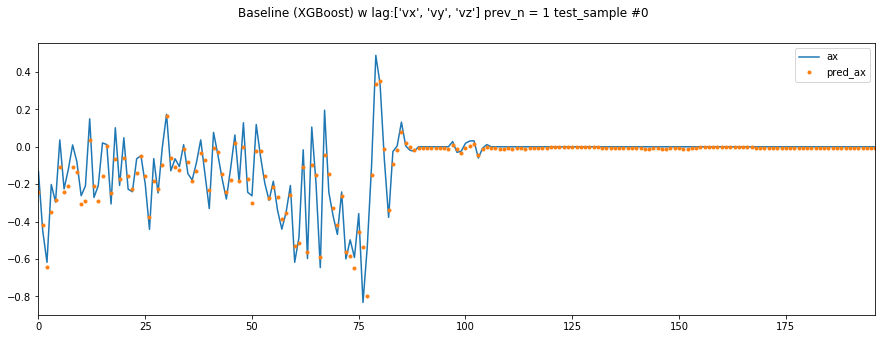

In [62]:
import matplotlib.pyplot as plt

sub_test = test.loc[:196]

sub_test = sub_test.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = sub_test[['ax', 'pred_ax']].plot(ax=ax, style=['-','.'])
plot = plt.suptitle("Baseline (XGBoost) w lag:['vx', 'vy', 'vz'] prev_n = 1 test_sample #0")